In [1]:
import time
import os
import numpy as np
import math
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import layers, models

tf.get_logger().setLevel('ERROR')

In [2]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Load data

In [4]:
# DATA_DIR = "./numbers/"
DATA_DIR = "./eval_data//"
CHECKPOINT_PATH = "./models/"
BATCH_SIZE = None
IMG_HEIGHT = 28
IMG_WIDTH = 28
TRAIN_VAL_RATIO = 0.01

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=TRAIN_VAL_RATIO,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale')

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=TRAIN_VAL_RATIO,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale')

Found 3522 files belonging to 10 classes.
Using 3487 files for training.
Found 3522 files belonging to 10 classes.
Using 35 files for validation.


In [18]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [19]:
x_train.shape

(60000, 28, 28)

In [20]:
x_train, x_test = np.array(x_train, np.uint8), np.array(x_test, np.uint8)
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

y_train = np.array(y_train, np.int64)
y_test = np.array(y_test, np.int64)
# x_train, self.y_train, self.x_val, self.y_val = self.split_data(self.rnd, val_size // 10, self.x_train,
#                                                                      self.y_train)

In [21]:
x_train.shape, x_train.dtype

((60000, 28, 28, 1), dtype('uint8'))

In [22]:
t_data,t_label = zip(*[(a.numpy(),b.numpy()) for a,b in iter(train_ds)])
v_data,v_label = zip(*[(a.numpy(),b.numpy()) for a,b in iter(val_ds)])

In [23]:
train_x = np.array(t_data, np.uint8)
train_y = np.array(t_label, np.int64)
test_x = np.array(v_data, np.uint8)
test_y = np.array(v_label, np.int64)

In [24]:
print(train_x.shape, train_y.shape, x_train.shape, y_train.shape)
print(test_x.shape, test_y.shape, x_test.shape, y_test.shape)

(3487, 28, 28, 1) (3487,) (60000, 28, 28, 1) (60000,)
(35, 28, 28, 1) (35,) (10000, 28, 28, 1) (10000,)


In [25]:
train_x = np.concatenate((train_x, x_train), axis=0)
train_y = np.concatenate((train_y, y_train), axis=0)
test_x = np.concatenate((test_x, x_test), axis=0)
test_y = np.concatenate((test_y, y_test), axis=0)

In [26]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(63487, 28, 28, 1) (63487,)
(10035, 28, 28, 1) (10035,)


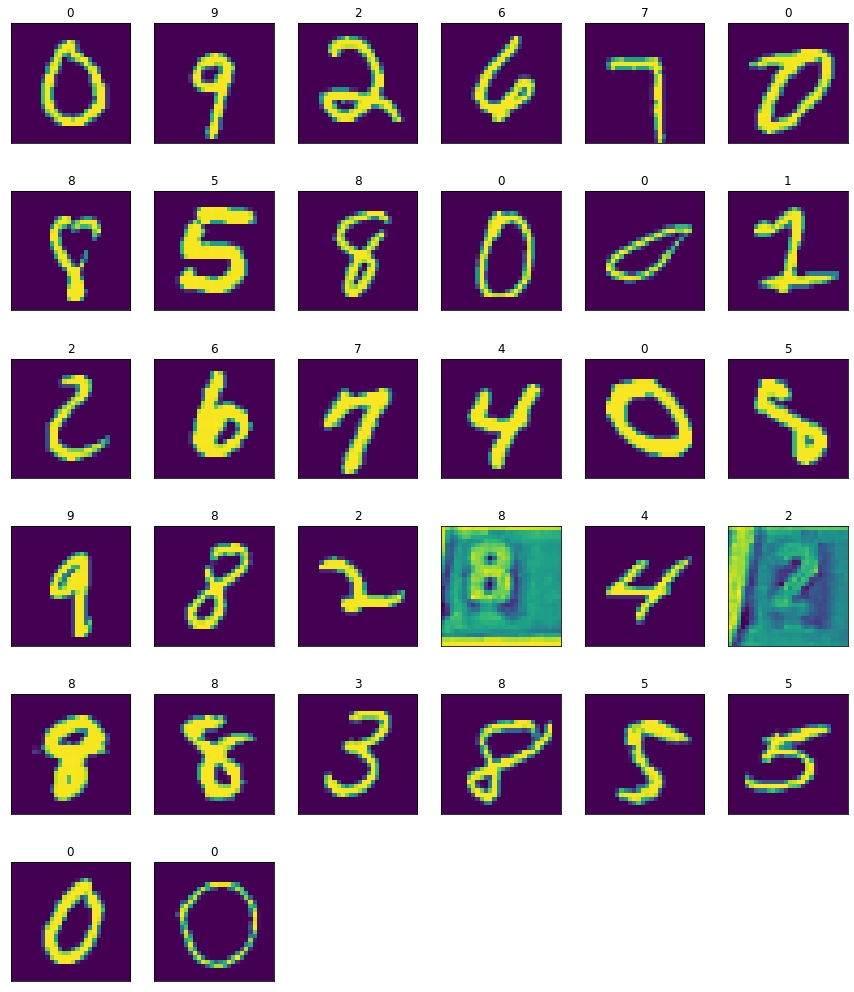

In [27]:
idx = np.random.permutation(len(train_x))
idx = idx[0:32]
x,y = train_x[idx], train_y[idx]

dim = math.ceil(math.sqrt(len(x)))
rows = dim
cols = dim
fig = plt.figure(figsize=[15, 18])

for i, img in enumerate(x): 
    # print(lbl)
    # print(img)
    ax = plt.subplot(rows, cols, (i + 1))
    plt.xticks([]) 
    plt.yticks([]) 
    plt.imshow(img)
    plt.title(y[i])
plt.show()

# Define model structure and callback

In [28]:
def create_model():

    resize_and_rescale = tf.keras.Sequential([
      # tf.keras.layers.Resizing(IMG_WIDTH, IMG_HEIGHT),
      tf.keras.layers.Rescaling(1./255)
    ])

    data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomRotation(0.15)
            # tf.keras.layers.RandomContrast(0.5)
        ])
    
    model = models.Sequential()
    model.add(resize_and_rescale)
    model.add(data_augmentation)
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    return model

In [29]:
cur_time = round(time.time())

# checkpoint_filepath = './local_models/' + str(cur_time) + "/" + 'val_acc_{val_accuracy:.2f}_'
checkpoint_filepath = CHECKPOINT_PATH + str(cur_time) + "/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model training

In [47]:
model = create_model()

In [48]:
optimizer = tf.keras.optimizers.Adam(learning_rate=10e-4)
model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [205]:
history = model.fit(
    train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=30,
    batch_size=128,
    shuffle=True
    # callbacks=[model_checkpoint_callback]
)

Epoch 1/30
496/496 [==============================] - 35s 67ms/step - loss: 0.4025 - accuracy: 0.8738 - val_loss: 0.1019 - val_accuracy: 0.9680
Epoch 2/30
496/496 [==============================] - 33s 66ms/step - loss: 0.1516 - accuracy: 0.9525 - val_loss: 0.0781 - val_accuracy: 0.9746
Epoch 3/30
496/496 [==============================] - 33s 66ms/step - loss: 0.1169 - accuracy: 0.9642 - val_loss: 0.0534 - val_accuracy: 0.9834
Epoch 4/30
496/496 [==============================] - 33s 66ms/step - loss: 0.0977 - accuracy: 0.9692 - val_loss: 0.0472 - val_accuracy: 0.9853
Epoch 5/30
496/496 [==============================] - 33s 67ms/step - loss: 0.0843 - accuracy: 0.9743 - val_loss: 0.0401 - val_accuracy: 0.9878
Epoch 6/30
496/496 [==============================] - 33s 67ms/step - loss: 0.0734 - accuracy: 0.9774 - val_loss: 0.0443 - val_accuracy: 0.9868
Epoch 7/30
496/496 [==============================] - 33s 67ms/step - loss: 0.0655 - accuracy: 0.9792 - val_loss: 0.0404 - val_accuracy:

In [69]:
optimizer = tf.keras.optimizers.Adam(learning_rate=10e-5)
model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [212]:
history = model.fit(
    train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=10,
    batch_size=128
    # callbacks=[model_checkpoint_callback]
)

Epoch 1/30
496/496 [==============================] - 36s 70ms/step - loss: 0.0132 - accuracy: 0.9960 - val_loss: 0.0292 - val_accuracy: 0.9914
Epoch 2/30
496/496 [==============================] - 34s 69ms/step - loss: 0.0103 - accuracy: 0.9971 - val_loss: 0.0287 - val_accuracy: 0.9918
Epoch 3/30
496/496 [==============================] - 35s 71ms/step - loss: 0.0103 - accuracy: 0.9967 - val_loss: 0.0283 - val_accuracy: 0.9918
Epoch 4/30
496/496 [==============================] - 34s 70ms/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 0.0291 - val_accuracy: 0.9916
Epoch 5/30
496/496 [==============================] - 34s 69ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.0282 - val_accuracy: 0.9919
Epoch 6/30
496/496 [==============================] - 34s 69ms/step - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.0281 - val_accuracy: 0.9923
Epoch 7/30
496/496 [==============================] - 34s 69ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0288 - val_accuracy:

In [296]:
model.save_weights('./final9/')

# Load model

In [30]:
model = create_model()
model.load_weights('./final9/')

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=10e-5)
model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [32]:
model.evaluate(train_x, train_y)
model.evaluate(test_x, test_y)

314/314 [==============================] - 1s 5ms/step - loss: 0.0359 - accuracy: 0.9915


[0.03591866046190262, 0.991529643535614]

# Model evaluation

## Plot train_ds

In [ ]:
# prediction = model.predict(train_ds)
# model.evaluate(train_ds)

# images, labels = zip(*[(x, y) for x, y in train_ds])
# labels = np.concatenate(labels, axis=0)
# images = np.concatenate(images, axis=0)
# print(labels.shape, type(prediction))

# wrongs = np.where(np.equal(predictions, labels) == False)[0]
# wrongs

## Plot test_x

In [71]:
images, labels = test_x, test_y

In [72]:
# prediction = model.predict(train_ds)
# model.evaluate(train_ds)

prediction = model.predict(test_x)
model.evaluate(test_x,test_y)

all_class_predictions = prediction
predictions = np.argmax(prediction, axis=1)
print(predictions.shape, type(prediction))

wrongs = np.where(np.equal(predictions, test_y) == False)[0]
print(wrongs)

314/314 [==============================] - 2s 5ms/step - loss: 0.0412 - accuracy: 0.9914
(10035,) <class 'numpy.ndarray'>
[  24   33   43  184  394  480  484  530  660  681  694  752  761  971
  973 1000 1033 1159 1261 1282 1295 1334 1428 1494 1543 1562 1656 1751
 1783 1913 1936 1938 1959 2075 2144 2170 2328 2364 2482 2497 2632 2689
 2806 2988 3030 3260 3351 3404 3457 3476 3843 3894 3941 4088 4236 4319
 4395 4522 4532 4539 4606 4734 4796 4858 4873 5711 5972 6566 6590 6595
 6611 6619 6632 6660 6686 8094 8114 8443 8562 8688 9662 9669 9714 9727
 9733 9764]


In [73]:
len(all_class_predictions), len(predictions), len(labels), len(images)

(10035, 10035, 10035, 10035)

## Plot train_x

In [62]:
images, labels = train_x, train_y

In [63]:
prediction = model.predict(train_x)
model.evaluate(train_x,train_y)

all_class_predictions = prediction
predictions = np.argmax(prediction, axis=1)
print(predictions.shape, type(prediction))

wrongs = np.where(np.equal(predictions, train_y) == False)[0]
print(wrongs)

1984/1984 [==============================] - 9s 5ms/step - loss: 0.0029 - accuracy: 0.9991
(63487,) <class 'numpy.ndarray'>
[ 2861  3516  3841  5539  6063  7616  8661 10567 11770 12879 14481 15263
 16001 16317 17149 18015 18448 18696 19617 21079 22321 24617 25687 25807
 26266 27563 30209 32927 37893 38797 39103 41303 42187 42798 42844 43865
 44940 46941 47749 49248 49927 51045 51224 51483 52729 53948 54092 54943
 55411 55431 56585 56655 56883 59357 60083 60918 63339 63402]


In [64]:
len(all_class_predictions), len(predictions), len(labels), len(images)

(63487, 63487, 63487, 63487)

## Plot

In [74]:
tup = np.asarray(list(zip(all_class_predictions, predictions, labels, images)), dtype=object)
tup = tup[wrongs]

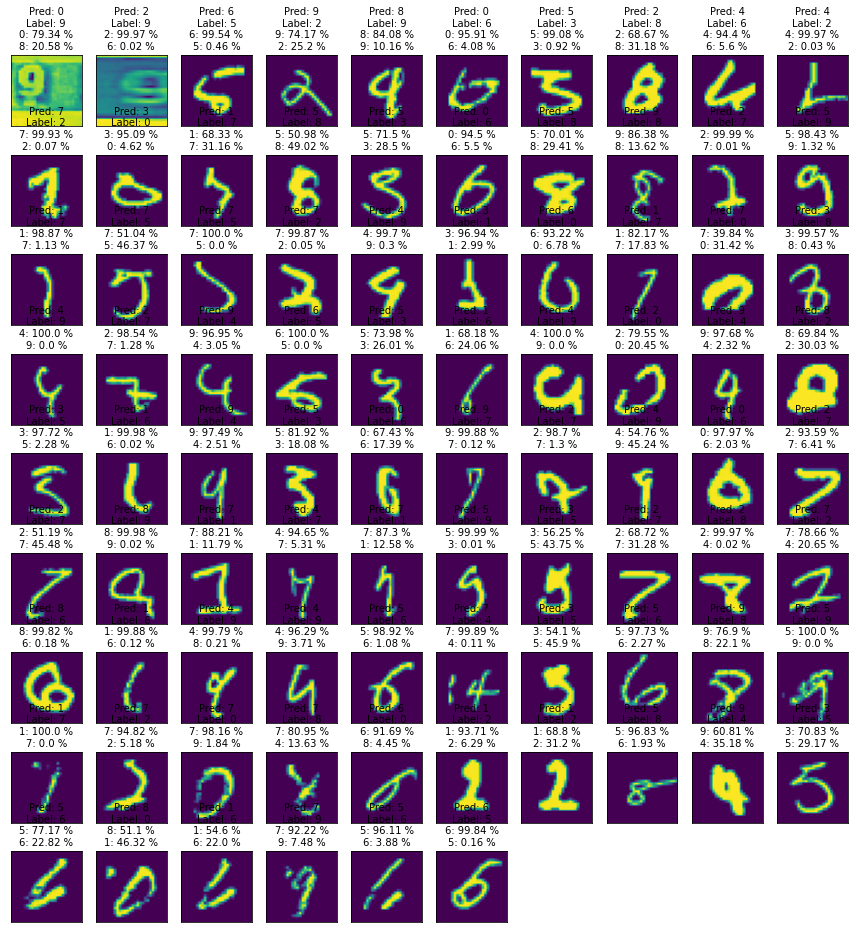

In [75]:
dim = math.ceil(math.sqrt(len(tup)))
rows = dim
cols = dim
fig = plt.figure(figsize=[15, 18])

for i, (all_class_prediction, prediction, label, img) in enumerate(tup): 
    ax = plt.subplot(rows, cols, (i + 1))
    # ax.get_yaxis().set_visible(False)
    # ax.get_xaxis().set_visible(False)
    # ax.get_xlabel().set_visible_visible(True)
    # ax.set_xlabel()
    # disabling xticks by Setting xticks to an empty list
    plt.xticks([]) 

    # disabling yticks by setting yticks to an empty list
    plt.yticks([]) 
    plt.imshow(img/255.)
    # plt.axis('off')
    plt.title("Pred: " + str(prediction) + "\n" + "Label: " + str(label) + "\n" +
             str(np.argsort(all_class_prediction)[-1]) + ": " +
             str(round(sorted(all_class_prediction * 100)[-1], 2)) + " %" + "\n" + 
             str(np.argsort(all_class_prediction)[-2]) + ": " +
             str(round(sorted(all_class_prediction * 100)[-2], 2))  + " %", fontsize=10)
    # print(softmax(all_class_prediction))
    # print(str(round(np.max(all_class_prediction) * 100, 2)) + " %")
    # plt.xlabel("Pred: " + str(prediction) + " " + "Label: " + str(label), fontsize=8)
plt.show()

# Image prediction

## Clear the folders of results

In [33]:
import glob

### Numberplate

In [34]:
root = "result_2/"

In [35]:
paths = [di for di in glob.glob(root + "*") if os.path.isfile(di)]

In [36]:
paths[:2]

[]

In [37]:
for filename in paths:
    os.remove(filename)

### Numbers

In [38]:
root = "result_5/"

In [39]:
paths = [di + "/" for di in glob.glob(root + "*") if os.path.isdir(di)]

In [40]:
paths[:2]

['result_5/1/', 'result_5/4/']

In [41]:
for folder in paths:
    filenames = glob.glob(folder + "*.jpg")
    for filename in filenames:
        os.remove(filename)

### Intermediate results

In [42]:
root = "intermediate_results/"

In [43]:
paths = [di + "/" for di in glob.glob(root + "*") if os.path.isdir(di)]

In [44]:
paths[:2]

['intermediate_results/0_balanced_images/',
 'intermediate_results/2_resized_and_sharp_images/']

In [45]:
for folder in paths:
    filenames = glob.glob(folder + "*.jpg")
    for filename in filenames:
        os.remove(filename)

In [46]:
import datetime

from tflite_support.task import core
from tflite_support.task import processor
from helper_functions import *
import cv2
from tqdm import tqdm

In [47]:
VERBOSE = False

In [48]:
#Image paths
SOURCE_IMG_PATH = "./images/"
RESULT_IMG_PATH = "result_2/"

#Parameters of object detection
WIDTH = 1000
HEIGHT = 140
DIM = (WIDTH, HEIGHT)
NUM_THREADS = 10
# DETECTOR_PATH = './numberplate_detector.tflite'
DETECTOR_PATH = './object_detector.tflite'

#Parameters of balancing algorithm (Hugh Lines)
balancing_cycles = 3

#Parameters of sharpener algorithm
tb_w = 50
tb_th = 0
tb_blur_size = 10
tb_blur_sigma = 50

#Adaptive threshold and blur
blockSize = 65
k = 0.3

#Contours
h_min = 50
w_min = 25
w_max = 120
x_min = 25
x_max = 400
h_w_ratio_max = 3
h_w_ratio_min = 1.25


#Tensorflow image classification model
# CHECKPOINT_PATH = "./final/"
# IMG_WIDTH = 28
# IMG_HEIGHT = 28

In [49]:
def analyze(image, detector, filename):

    greyscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Balance image
    balanced_image = balancing_tilted_image(image, greyscale_image, balancing_cycles)
    cv2.imwrite(f'./intermediate_results/0_balanced_images/' + filename, balanced_image)
    # cv2.imread('Imgae', balanced_image)
    # cv2.waitKey(0)
    
    #Object detection and crop detected area
    detected_image = detect_numberplate(detector, balanced_image)
    cv2.imwrite(f'./intermediate_results/1_detected_images/' + filename, detected_image)
    # cv2.imread('Imgae', detected_image)
    # cv2.waitKey(0)

    #Resize and sharpen image
    resized_sharp_image = resize_and_sharpen_image(detected_image, DIM, tb_w, tb_th, tb_blur_size, tb_blur_sigma)
    cv2.imwrite(f'./intermediate_results/2_resized_and_sharp_images/' + filename, resized_sharp_image)
    # cv2.imread('Imgae', resized_sharp_image)
    # cv2.waitKey(0)

    #Niblack threshold and medianblur
    threshold_image = adaptive_threshold_and_median_blur(resized_sharp_image, blockSize, k)
    # cv2.imread('Imgae', threshold_image)
    # cv2.waitKey(0)


    IMG_WIDTH = model.layers[0].input_shape[1]
    IMG_HEIGHT = model.layers[0].input_shape[2]

    #Contours and clip image into 8 pieces
    image_list, threshold_im = find_contours(threshold_image, resized_sharp_image, IMG_WIDTH, IMG_HEIGHT, h_min=h_min, w_min=w_min, w_max=w_max, x_min=x_min, x_max=x_max, h_w_ratio_max=h_w_ratio_max, h_w_ratio_min=h_w_ratio_min)
    cv2.imwrite(f'./intermediate_results/3_threshold_images/' + filename, threshold_im)
    
    
    # print(tf.image.rgb_to_grayscale(image_list))
    # tensor = tf.convert_to_tensor(image_list)
    tensor = tf.image.rgb_to_grayscale(image_list)
    prediction_array = np.argmax(model.predict(tensor, verbose=False), axis=1)
    prediction_str = ''.join([str(num) for num in prediction_array])
    
    for i, im in enumerate(image_list):
        cv2.imwrite(f'./result_5/{prediction_array[i]}/' + '_l3_' + filename, im)
        # cv2.imread('Imgae', im)
        # cv2.waitKey(0)
    
    return prediction_str, resized_sharp_image, image_list

In [50]:
def normalize_image(image, img_width, img_height):
    # image = image / 255.
    image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_LANCZOS4)
    return image

In [54]:
base_options = core.BaseOptions(
    file_name=DETECTOR_PATH, use_coral=False, num_threads=NUM_THREADS)
detection_options = processor.DetectionOptions(
    max_results=3, score_threshold=0.1)
options = vision.ObjectDetectorOptions(
    base_options=base_options, detection_options=detection_options)
detector = vision.ObjectDetector.create_from_options(options)


path_list = [SOURCE_IMG_PATH + file for file in os.listdir(SOURCE_IMG_PATH) if '.jpg' in file]
filename_list = [file for file in os.listdir(SOURCE_IMG_PATH) if '.jpg' in file]

skipped_images = []

for i, img_path in tqdm(enumerate(path_list), total=len(path_list)):
    try:
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        pred, img, image_list = analyze(image, detector, filename_list[i])
        cv2.imwrite(RESULT_IMG_PATH + f"{i}_" + pred[:-3] + "_" + pred[-3:] + ".jpg", img)

        with open(RESULT_IMG_PATH + "result_images.csv", 'a') as f:
            # f.write(f"{datetime.datetime.now()}, {pred}\n")
            f.write(f"{filename_list[i]}, {pred}\n")
    except Exception as e:
        # print(img_path, e)
        skipped_images.append(img_path)
        try:
            cv2.imwrite("Unprocessed_images/" + f"{filename_list[i]}_" + ".jpg", image)
        except Exception as exc:
            print(exc, "--------------")

100%|█████████████████████████████████████████| 839/839 [04:52<00:00,  2.87it/s]


## Display unprocessed images

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


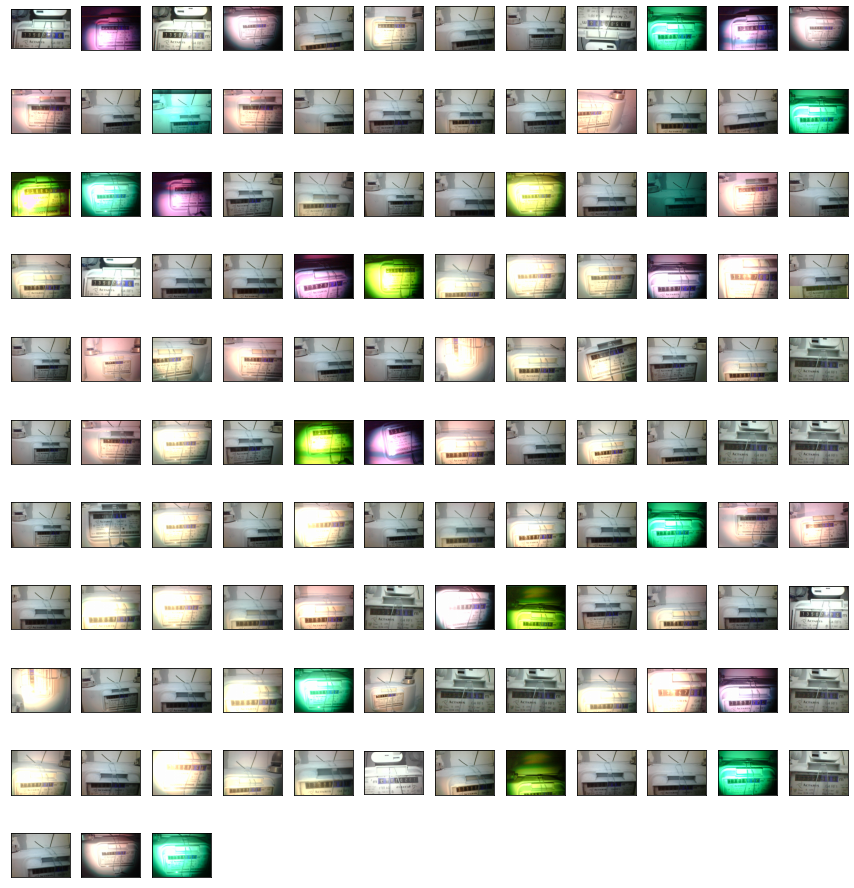

In [55]:
dim = math.ceil(math.sqrt(len(skipped_images)))
rows = dim
cols = dim
fig = plt.figure(figsize=[15, 18])

for i, img_path in enumerate(skipped_images): 
    img = cv2.imread(img_path)
    ax = plt.subplot(rows, cols, (i + 1))
    plt.xticks([]) 
    plt.yticks([]) 
    plt.imshow(img/255.)
plt.show()

# Convert model to .tflite

In [56]:
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [57]:
# tflite_model = converter.convert()

In [58]:
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

# Analyzing csv data

## Load csv data

In [59]:
df = pd.read_csv('./result_2/result_images.csv', header=None)

## Sort data by time 

In [60]:
df_sorted = df.sort_values(by=0)

## Selecting data by value

In [61]:
MIN_VAL = 13641876
MAX_VAL = 13800000

In [62]:
df_sorted = df_sorted[df_sorted[1] > MIN_VAL]
df_sorted = df_sorted[df_sorted[1] < MAX_VAL]

In [63]:
df_sorted[1] = df_sorted[1].apply(lambda x: x/1000.)

In [64]:
df_sorted.head(2)

,0,1
345,2022-10-24T18:24:56_227+02:00.jpg,13667.981
188,2022-10-24T19:46:40_691+02:00.jpg,13647.160


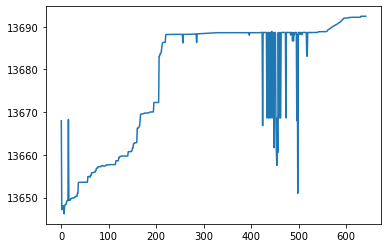

In [66]:
plt.plot(list(df_sorted[1]))
plt.show()

## Creating timestamp from filenames

In [67]:
def timestamp_from_date(string) -> int:
    daymonth, time = string[:-10].split('T')
    year, month, day = daymonth.split('-')
    h, m ,sms = time.split(':')
    s, ms = sms.split('_')
    x_datetime = datetime.datetime(int(year),int(month),int(day),int(h),int(m),int(s),int(ms))
    return datetime.datetime.timestamp(x_datetime)

## Clean data

In [68]:
tu = list(zip(df_sorted[0],list(df_sorted[1])))

In [84]:
tu[0]

('2022-10-24T18:24:56_227+02:00.jpg', 13667.981)

In [70]:
clean = []
for i,t in enumerate(tu):
    if i == 0 or i == len(tu)-1:
        continue
    else:
        current = tu[i][1]
        left_nb = tu[i-1][1]
        right_nb = tu[i+1][1]
        
        diff_left = current- left_nb
        diff_right = right_nb - current
        if diff_left >= 0 and diff_left < 1 and \
            diff_right >= 0 and diff_right < 1:
            clean.append(t)
       

In [71]:
len(tu), len(clean)

(642, 500)

In [86]:
list(set(tu) - set(clean))

[('2022-11-03T17:00:28_112+02:00.jpg', 13668.626),
 ('2022-11-03T17:32:50_374+02:00.jpg', 13688.651),
 ('2022-11-03T16:55:42_571+02:00.jpg', 13688.649),
 ('2022-11-03T17:32:46_469+02:00.jpg', 13661.665),
 ('2022-11-03T17:33:24_647+02:00.jpg', 13660.521),
 ('2022-10-30T17:52:05_608+02:00.jpg', 13672.265),
 ('2022-11-04T00:01:39_294+02:00.jpg', 13692.163),
 ('2022-10-30T00:00:08_252+02:00.jpg', 13670.071),
 ('2022-10-30T18:21:58_543+02:00.jpg', 13672.263),
 ('2022-11-02T22:53:07_873+02:00.jpg', 13686.329),
 ('2022-10-28T22:33:02_812+02:00.jpg', 13662.825),
 ('2022-11-03T17:33:34_352+02:00.jpg', 13668.651),
 ('2022-11-03T17:38:01_514+02:00.jpg', 13688.551),
 ('2022-11-03T16:16:37_889+02:00.jpg', 13688.649),
 ('2022-11-03T17:32:04_439+02:00.jpg', 13688.651),
 ('2022-11-01T22:55:49_244+02:00.jpg', 13683.093),
 ('2022-11-03T17:55:25_497+02:00.jpg', 13688.611),
 ('2022-10-26T18:26:12_314+02:00.jpg', 13653.6),
 ('2022-11-03T16:56:59_337+02:00.jpg', 13688.646),
 ('2022-11-01T22:50:35_649+02:00.

In [72]:
filenames, results = zip(*clean)
print(len(results),"---",len(filenames),"---", results[0],"---", filenames[0])

500 --- 500 --- 13647.573 --- 2022-10-24T19:53:43_192+02:00.jpg


## Create new dataframe with extra columns (year,month,day etc.)

In [73]:
df_cleaned = pd.DataFrame()
df_cleaned["filenames"] = filenames
df_cleaned["measured_values"] = results

In [74]:
df_cleaned["stamp"] = df_cleaned["filenames"].apply(timestamp_from_date)
df_cleaned["year"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).year)
df_cleaned["month"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).month)
df_cleaned["day"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).day)

df_cleaned["hour"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)
df_cleaned["minute"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).minute)
df_cleaned["second"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).second)

df_cleaned["ms"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).microsecond)

In [75]:
df_cleaned.head()

,filenames,measured_values,stamp,year,month,day,hour,minute,second,ms
0,2022-10-24T19:53:43_192+02:00.jpg,13647.573,1.666634e+09,2022,10,24,19,53,43,192
1,2022-10-24T20:53:18_127+02:00.jpg,13648.033,1.666638e+09,2022,10,24,20,53,18,127
2,2022-10-24T20:53:18_175+02:00.jpg,13648.033,1.666638e+09,2022,10,24,20,53,18,175
3,2022-10-24T23:25:15_530+02:00.jpg,13648.311,1.666647e+09,2022,10,24,23,25,15,530
4,2022-10-25T00:24:57_695+02:00.jpg,13648.397,1.666650e+09,2022,10,25,0,24,57,695


In [ ]:
date1 = datetime.datetime(2022,10,24,0,0,0)
day1 = datetime.datetime.timestamp(date1)

date2 = datetime.datetime(2022,10,25,0,0,0)
day2 = datetime.datetime.timestamp(date2)

In [ ]:
stamps = list(df_cleaned['stamp'])
start_date = datetime.datetime.fromtimestamp(stamps[0])
end_date = datetime.datetime.fromtimestamp(stamps[-1])

In [ ]:
date_diff = end_date - start_date

In [ ]:
start_date, end_date, date_diff

(datetime.datetime(2022, 10, 24, 19, 53, 43, 192),
 datetime.datetime(2022, 11, 4, 12, 22, 56, 430),
 datetime.timedelta(days=10, seconds=59353, microseconds=238))

In [ ]:
date_diff.days

11

In [ ]:
daylines = [datetime.datetime.timestamp(start_date)+i*86400 for i in range(date_diff.days + 3)]

In [ ]:
daylines[0] - daylines[0] % 86400

1666569600.0

In [264]:
daylines = [stamp - stamp % 86400 for stamp in daylines]

In [265]:
dates = [datetime.datetime.fromtimestamp(stamp) for stamp in daylines]

In [266]:
dates

[datetime.datetime(2022, 10, 24, 2, 0),
 datetime.datetime(2022, 10, 25, 2, 0),
 datetime.datetime(2022, 10, 26, 2, 0),
 datetime.datetime(2022, 10, 27, 2, 0),
 datetime.datetime(2022, 10, 28, 2, 0),
 datetime.datetime(2022, 10, 29, 2, 0),
 datetime.datetime(2022, 10, 30, 2, 0),
 datetime.datetime(2022, 10, 31, 1, 0),
 datetime.datetime(2022, 11, 1, 1, 0),
 datetime.datetime(2022, 11, 2, 1, 0),
 datetime.datetime(2022, 11, 3, 1, 0),
 datetime.datetime(2022, 11, 4, 1, 0),
 datetime.datetime(2022, 11, 5, 1, 0)]

In [267]:
now = datetime.datetime(1970,1,1,1,0,0,0)

In [268]:
datetime.datetime.timestamp(now)

0.0

In [269]:
datetime.date.fromtimestamp(0)

datetime.date(1970, 1, 1)

In [292]:
df_cleaned['datetime'] = df_cleaned['stamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df_cleaned['date'] = df_cleaned['stamp'].apply(lambda x: datetime.date.fromtimestamp(x))

In [293]:
df_cleaned

,filenames,measured_values,stamp,year,month,day,hour,minute,second,ms,datetime,date
0,2022-10-24T19:53:43_192+02:00.jpg,13647.573,1.666634e+09,2022,10,24,19,53,43,192,2022-10-24 19:53:43.000192,2022-10-24
1,2022-10-24T20:53:18_127+02:00.jpg,13648.033,1.666638e+09,2022,10,24,20,53,18,127,2022-10-24 20:53:18.000127,2022-10-24
2,2022-10-24T20:53:18_175+02:00.jpg,13648.033,1.666638e+09,2022,10,24,20,53,18,175,2022-10-24 20:53:18.000175,2022-10-24
3,2022-10-24T23:25:15_530+02:00.jpg,13648.311,1.666647e+09,2022,10,24,23,25,15,530,2022-10-24 23:25:15.000530,2022-10-24
4,2022-10-25T00:24:57_695+02:00.jpg,13648.397,1.666650e+09,2022,10,25,0,24,57,695,2022-10-25 00:24:57.000695,2022-10-25
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2022-11-04T12:02:56_414+02:00.jpg,13692.453,1.667560e+09,2022,11,4,12,2,56,414,2022-11-04 12:02:56.000414,2022-11-04
496,2022-11-04T12:07:56_437+02:00.jpg,13692.453,1.667560e+09,2022,11,4,12,7,56,437,2022-11-04 12:07:56.000437,2022-11-04
497,2022-11-04T12:12:56_493+02:00.jpg,13692.453,1.667560e+09,2022,11,4,12,12,56,493,2022-11-04 12:12:56.000493,2022-11-04
498,2022-11-04T12:17:56_332+02:00.jpg,13692.453,1.667561e+09,2022,11,4,12,17,56,332,2022-11-04 12:17:56.000332,2022-11-04


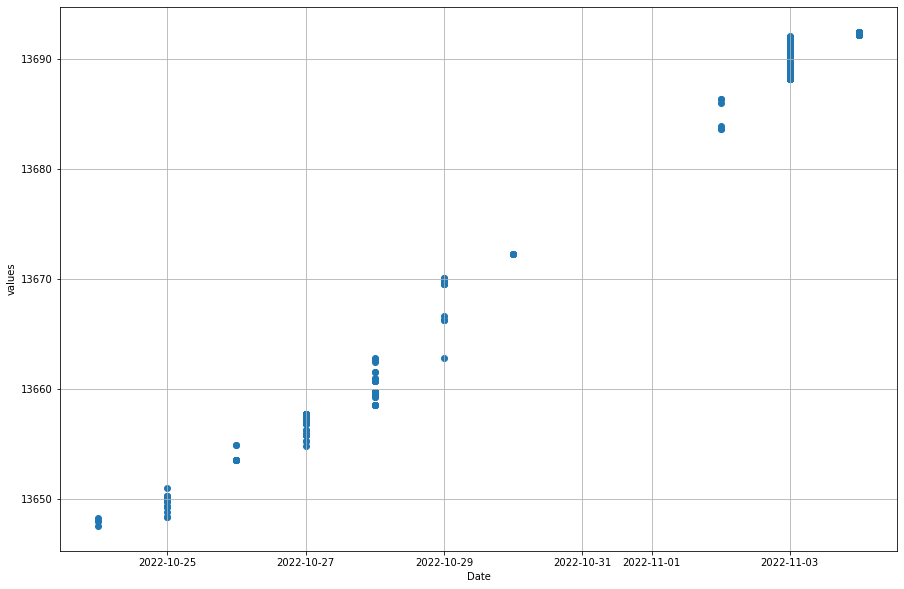

In [299]:
plt.figure(figsize=(15,10))
plt.scatter(df_cleaned['date'], df_cleaned['measured_values'])
# for line in daylines:
#     plt.axvline(x = line, color = 'gray', label = 'axvline - full height')
#     plt.text(10.1,0,'blah',rotation=90)
plt.grid()
plt.xlabel('Date')
plt.ylabel('values')
plt.show()

In [88]:
# df_cleaned[df_cleaned['year']]

In [89]:
df_cleaned['day'].unique()

array([24, 25, 26, 27, 28, 29, 30,  2,  3,  4])

In [90]:
df_cleaned['month'].unique()

array([10, 11])

In [91]:
df_cleaned

,filenames,measured_values,stamp,year,month,day,hour,minute,second,ms
0,2022-10-24T19:53:43_192+02:00.jpg,13647.573,1.666634e+09,2022,10,24,19,53,43,192
1,2022-10-24T20:53:18_127+02:00.jpg,13648.033,1.666638e+09,2022,10,24,20,53,18,127
2,2022-10-24T20:53:18_175+02:00.jpg,13648.033,1.666638e+09,2022,10,24,20,53,18,175
3,2022-10-24T23:25:15_530+02:00.jpg,13648.311,1.666647e+09,2022,10,24,23,25,15,530
4,2022-10-25T00:24:57_695+02:00.jpg,13648.397,1.666650e+09,2022,10,25,0,24,57,695
...,...,...,...,...,...,...,...,...,...,...
495,2022-11-04T12:02:56_414+02:00.jpg,13692.453,1.667560e+09,2022,11,4,12,2,56,414
496,2022-11-04T12:07:56_437+02:00.jpg,13692.453,1.667560e+09,2022,11,4,12,7,56,437
497,2022-11-04T12:12:56_493+02:00.jpg,13692.453,1.667560e+09,2022,11,4,12,12,56,493
498,2022-11-04T12:17:56_332+02:00.jpg,13692.453,1.667561e+09,2022,11,4,12,17,56,332


In [92]:
import sqlite3

In [93]:
!rm gasmeter_numbers.db

In [94]:
connection = sqlite3.connect("gasmeter_numbers.db")

In [95]:
cursor = connection.cursor()

In [96]:
# CREATE_TABLE = "CREATE TABLE measured_values ( \
#                 filename TEXT, \
#                 measured_values INTEGER, \
#                 timestamp FLOAT,  \
#                 year INTEGER, \
#                 month INTEGER, \
#                 day INTEGER, \
#                 hour INTEGER, \
#                 minute INTEGER, \
#                 second INTEGER)"

In [97]:
# cursor.execute(CREATE_TABLE)

In [98]:
# print(connection.total_changes)

In [99]:
# connection.tables

In [100]:
# con = sqlite3.connect('database.db')
# cursor = con.cursor()
# cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
# print(cursor.fetchall())

In [101]:
# INSERT = "INSERT INTO measured_values VALUES ()"

In [102]:
# for index, row in df_cleaned.iterrows():
#     print(index, row['year'], row['month'])
#     break

In [103]:
df_cleaned.to_sql(name="val", con=connection)

In [104]:
SELECT = "SELECT filenames, measured_values, stamp, year, month, day, hour, minute, second FROM val"
SELECT = "SELECT filenames, measured_values, stamp, year, month, day, hour, minute, second FROM val"
WHERE = " WHERE month = 11"
# WHERE = " WHERE hour < 12"
# WHERE = " WHERE hour < 12"
# WHERE = " WHERE hour < 12"
# WHERE = " WHERE hour < 12"
# WHERE = " WHERE hour < 12"


In [105]:
result = cursor.execute(SELECT + WHERE ).fetchall()

In [106]:
len(result)

334

In [107]:
df_query = pd.DataFrame(result, columns=list(df_cleaned.columns)[:-1])

In [108]:
df_query

,filenames,measured_values,stamp,year,month,day,hour,minute,second
0,2022-11-02T19:05:44_127+02:00.jpg,13683.653,1.667412e+09,2022,11,2,19,5,44
1,2022-11-02T19:35:37_379+02:00.jpg,13683.656,1.667414e+09,2022,11,2,19,35,37
2,2022-11-02T19:53:27_666+02:00.jpg,13683.936,1.667415e+09,2022,11,2,19,53,27
3,2022-11-02T21:53:19_541+02:00.jpg,13686.016,1.667422e+09,2022,11,2,21,53,19
4,2022-11-02T22:23:14_835+02:00.jpg,13686.329,1.667424e+09,2022,11,2,22,23,14
...,...,...,...,...,...,...,...,...,...
329,2022-11-04T12:02:56_414+02:00.jpg,13692.453,1.667560e+09,2022,11,4,12,2,56
330,2022-11-04T12:07:56_437+02:00.jpg,13692.453,1.667560e+09,2022,11,4,12,7,56
331,2022-11-04T12:12:56_493+02:00.jpg,13692.453,1.667560e+09,2022,11,4,12,12,56
332,2022-11-04T12:17:56_332+02:00.jpg,13692.453,1.667561e+09,2022,11,4,12,17,56


In [109]:
data = list(df_query['measured_values'])

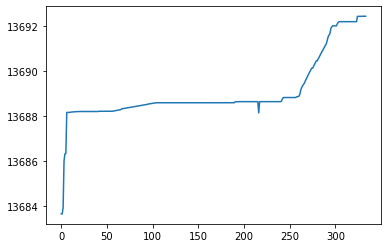

In [110]:
plt.plot(data)
plt.show()